### Steps for downloading GBIF data for another species for your portfolio post

#### Step 1: choose a terrestrial species that migrates (and find its scientific/Latin name)

#### Step 2: make an account on [gbif.org](<https://www.gbif.org/)>)

#### Step 3: Install the pygbif package in your python environment

If you're on a Mac, just run this code chunk:

In [21]:
!pip install pygbif


If you're on a PC, open Git Bash in the Terminal at the bottom of the Jupyter notebook, and enter this: 

`pip install pygbif`

#### Step 4: load the packages you'll need

In [22]:
import pathlib
import os
import pygbif.occurrences as occ
import pygbif.species as species


#### Step 5: make a folder for your GBIF data
You'll need to modify this code to match your folder structure:

In [23]:
### create data directory
crane_dir = os.path.join(

    ### home directory
    pathlib.Path.home(),

    ### folder with assignments for this class
    'earth-analytics',
    'data',
    'class_demos',
    'orca')


### make the directory
os.makedirs(crane_dir, exist_ok = True)

### define directory for gbif data
gbif_dir = os.path.join(crane_dir, 'gbif')

### make the directory
os.makedirs(gbif_dir, exist_ok = True)

#### Step 6: link GBIF to your Jupyter notebook
- Change to `reset = True` the first time you run it. When you run it, you'll be prompted to enter your GBIF username, password, and associated email address
- Then change it back to `reset = False` so you can re-run the chunk without having to reconnect to GBIF
- You don’t need to modify this code chunk in any other way


In [24]:
####--------------------------####
#### DO NOT MODIFY THIS CODE! ####
####--------------------------####
# This code ASKS for your credentials 
# and saves it for the rest of the session.
# NEVER put your credentials into your code!!!!

# GBIF needs a username, password, and email
# All 3 need to match the account

import os
from getpass import getpass

# Change this to True the first time you run it.
# Then switch it back to False afterward so you don’t have to re-enter info.
reset = False

# Request and store username
if (not ('GBIF_USER' in os.environ)) or reset:
    os.environ['GBIF_USER'] = input('GBIF username:')

# Securely request and store password
if (not ('GBIF_PWD' in os.environ)) or reset:
    os.environ['GBIF_PWD'] = getpass('GBIF password:')

# Request and store account email address
if (not ('GBIF_EMAIL' in os.environ)) or reset:
    os.environ['GBIF_EMAIL'] = input('GBIF email:')


#### Step 7: Get the species key for your species from GBIF using the `name_backbone` command
You'll need to modify this code with the scientific name of your species

In [25]:
### grab the species info
backbone = species.name_backbone(name = 'Orcinus orca')

### check it out
backbone

### pull out the species key
species_key = backbone['usageKey']

### check it out
species_key

2440483

#### Step 8: Run this code to download the GBIF data once
It might take several minutes for the data to download

Modify this code to update the year if you want data for a different year, and to use the correct data_dir for your file structure (my code says "gbif_dir")

In [26]:
# STEP 8 (search-based fallback): get Orca records for 2025 with coordinates and save a CSV

import os, pathlib
from glob import glob
import pandas as pd
from pygbif import occurrences as occ

# same folder you created earlier
gbif_dir = os.path.join(pathlib.Path.home(),'earth-analytics','data','class_demos','orca','gbif')
pathlib.Path(gbif_dir).mkdir(parents=True, exist_ok=True)

out_csv = os.path.join(gbif_dir, "occurrence_orca_2025.csv")

# page through GBIF results (no queued download, avoids 401 limit)
rows = []
offset = 0
page = 300          # GBIF max page size
max_records = 10000 # raise if you want more

while offset < max_records:
    res = occ.search(
        taxonKey=species_key,     # from Step 7
        hasCoordinate=True,
        year=2025,
        limit=page,
        offset=offset
    )
    batch = res.get("results", [])
    if not batch:
        break
    rows.extend(batch)
    if len(batch) < page:
        break
    offset += page

# keep useful columns if present
keep = [
    "key","decimalLongitude","decimalLatitude","country","stateProvince",
    "eventDate","year","month","day","basisOfRecord","occurrenceStatus",
    "individualCount","habitat","locality"
]
df = pd.DataFrame(rows)
if set(keep).issubset(df.columns):
    df = df[keep]

df.to_csv(out_csv, index=False)

# keep using the variable name expected below
gbif_path = out_csv
print("Saved:", gbif_path, "rows:", len(df))




Saved: /home/jovyan/earth-analytics/data/class_demos/orca/gbif/occurrence_orca_2025.csv rows: 3202


## Step 9: Load, visualize, and summarize the data
Now that my GBIF data for Orcas is saved, I can open the CSV, remove empty coordinate rows, and make a quick world map and country summary.


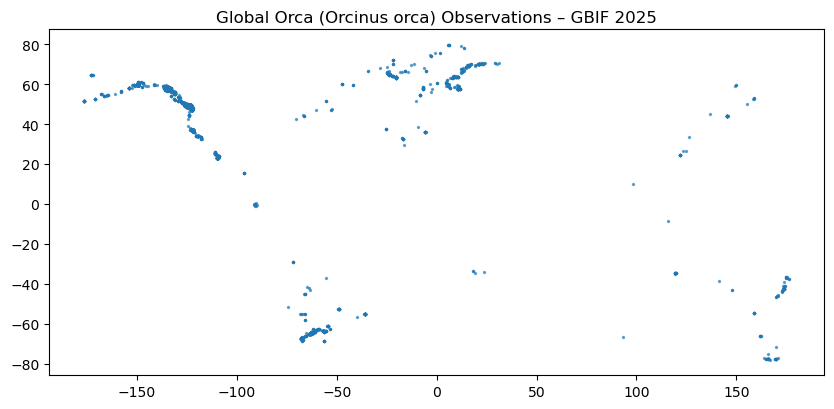

,Observations
country,
United States of America,1629
Canada,488
Antarctica,325
Norway,154
Mexico,124
Iceland,106
Denmark,41
New Zealand,39
South Georgia and the South Sandwich Islands,37


In [27]:
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import pandas as pd

# Load and clean the data
df = pd.read_csv(gbif_path)
df = df.dropna(subset=["decimalLongitude", "decimalLatitude"]).copy()

# Convert to a GeoDataFrame for mapping
gdf = gpd.GeoDataFrame(
    df,
    geometry=[Point(xy) for xy in zip(df["decimalLongitude"], df["decimalLatitude"])],
    crs="EPSG:4326"
)

# Plot the points
ax = gdf.plot(figsize=(10,6), markersize=2, alpha=0.6)
ax.set_title("Global Orca (Orcinus orca) Observations – GBIF 2025", fontsize=12)
plt.show()

# Summarize top 10 countries
summary = (
    gdf.assign(country=gdf["country"].fillna("Unknown"))
       .groupby("country")["key"].count()
       .sort_values(ascending=False)
       .head(10)
       .rename("Observations")
)
summary.to_frame()


## Step 10: Reflection
I downloaded and mapped Orca sightings from GBIF for 2025. Most of the points appear along coastlines like Norway and Canada. This shows how orcas shift ranges with prey and seasons, which is cool to see using real data.


The GBIF occurrence data should now be in a folder on your computer, saved as a .csv file. You can open it using the code structure we've used before to open .csv files using pandas.